(content:references:images_part1)=
# Images Part 1: *Galaxy Merger Classification*

***Author: Marc Hon***

The morphology of a galaxy reflects both its internal stellar dynamics and the imprint of processes driving star formation and galactic nuclei activity. Disturbed structures such as tidal tails, asymmetries, and double nuclei are signatures of recent or ongoing galaxy interactions, making morphology a powerful tracer of galaxy evolution.

**Galaxy mergers**, in particular, are one such important tracer to identify. In ΛCDM cosmology, galaxies grow hierarchically, through successive mergers of dark matter halos. Mergers are the observable imprint of this process, and are responsible for the following:

- Reshaping galactic structure (e.g., disks to spheroids)
- Triggering starbursts by driving gas inward
- Fueling active galactic nuclei (supermassive black holes) via central gas inflows

Therefore, identifying mergers is essential for testing predictions from cosmological simulations and understanding how galaxies assemble and transform over cosmic time.

```{figure} images/galaxy_formation_merger.jpg
---
height: 650px
width: 800px
name: galaxy_formation_merger
---
The hierarchical model of galaxy formation, in which small galaxies merge into ever larger galaxies over the lifetime of the Universe. Image credit: ESO/L. Calçada
```
Traditionally, galaxy morphology has been derived by the visual inspection of galaxy images, such as in the [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo) project, in which citizen scientists provide manual labels by eye. Even this, however, may soon be infeasible as modern surveys (e.g., SDSS, HST, JWST) will have cumulatively observed far greater than a million galaxies, demanding automated and scalable methods.

This chapter will demonstrate the use of modern machine learning data-driven analysis of galaxy morphology -- in particular convolutional neural networks (CNNs) for classifying galaxy mergers . This borrows upon the [notebook from Hello Universe!](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html), which itself is based upon the [DeepMerge](https://www.sciencedirect.com/science/article/abs/pii/S2213133720300445?via%3Dihub) analysis.

<!-- An alternative, is to use train machine learning methods on images
of simulated galaxy mergers from cosmological simulations. Here, we will show an example of classifying Galaxy mergers from snapshots by the Illustris-1 cosmological
simulation.
 -->



In [2]:
import os
import scienceplots
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm
from sklearn import metrics
from torchinfo import summary

plt.style.use('science'); fs=15

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter4' / 'data'

The dataset in this study will be synthetic galaxy observations (3-band images) generated by the Illustris-1 cosmological simulation. These are simulated to be observed in the following wavelength filters:

- F814W (Advanced Camera for Surveys - **Hubble Space Telescope**)
- F356W (Near Infrared Camera - **James Webb Space Telescope**)
- F160W (Wide Field Camera 3 - **Hubble Space Telescope**; Near Infrared Camera - **James Webb Space Telescope**)

The dataset contains images 8120 galaxy mergers and 7306 non-mergers alongside their labels, and can be downloaded from the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-pristine.fits).

```{note}
Because the image dataset occupies a relatively large disk space (2.1 GB) it is best downloaded separately, rather than being packaged together with this textbook. It is recommended that the dataset is downloaded to the data folder of this Chapter, done by using the `wget` library:

```python
from pathlib import Path
import os
import wget

url = "https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-pristine.fits"

target_folder = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter4' / 'data'

filename = os.path.join(str(target_folder), os.path.basename(url))
wget.download(url, out=filename)
```

## Dataset of Galaxy Mergers

In [ ]:
filename = '/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-pristine.fits'
hdu = fits.open(str(data_folder_path) + filename)

It's always a good idea to visualize our dataset to observe the diversity of examples contained within.


```{admonition} Visual Features of a Merger
:class: note

To identify a merger from an image of a galaxy, certain characteristic morphological disturbances are identified, including:

- Tails, bridges, and plumes from gravitational stripping -- **Tidal features**
- Two bright cores within a common envelope -- **Multiple galaxy nuclei**
- Nearby galaxies connected by distorted features -- **Close, disturbed pairs**
- Asymmetric light distribution, warped disks, twisted isophotes.
- Bright knots or clumps from interaction-induced starbursts.
- Diffuse structures: shells, ripples, or irregular halos.

```

In [11]:
def plot_random_selection(band = 'f814w'):
    
    band_idx = {'f814w' : 0,
          'f160w': 1, 
          'f356w': 2}

    example_ids = np.random.choice(hdu[1].data.shape[0], 16)
    examples = [hdu[0].data[j, band_idx[band], :, :] for j in example_ids]

    fig = plt.figure(figsize=(8, 8)) 
    for i, image in enumerate(examples):
        ax = fig.add_subplot(4, 4, i+1)
        norm = simple_norm(image, 'log', max_percent=99.75)

        ax.imshow(image, aspect='equal', cmap='binary_r', norm=norm)
        
        title = 'Merger' if bool(hdu[1].data[example_ids[i]][0]) else 'Non-Merger'
        ax.set_title(title, fontsize=fs-3)
        ax.axis('off')
    plt.show()

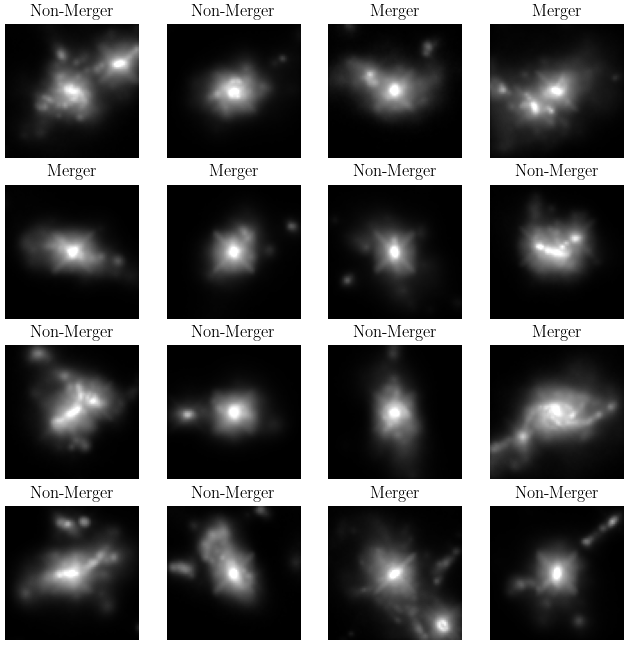

In [14]:
plot_random_selection(band='f356w')

Next, we will process the dataset into training and test sets for a standard **binary classification** task. The output vector `y` contains binary values in which `1` represents a merger, while `0` represents a non-merger.

In [37]:
X = hdu[0].data
y = hdu[1].data
X.shape, y

((15426, 3, 75, 75),
 FITS_rec([(1.,), (1.,), (1.,), ..., (0.,), (0.,), (0.,)],
          dtype=(numpy.record, [('MergerLabel', '>f8')])))

The input has dimensions of $N \times C \times W \times H$, where $C$ is the number of channels (three). Note that is already in the correct ordering required for Pytorch's 2D convolution. Next, the dataset will be split into *training*, *validation*, and *test* sets.

In [36]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

#### Train-Validation-Test Split ####

random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)


#### Convert to Tensor Datasets ####

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
valid_ds = TensorDataset(X_valid_tensor, y_valid_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

#### Create DataLoader ####

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

## 2D Convolutional Neural Network Classifier

Next, a simple 2D convolutional neural network is defined, having the following network architecture.

```{figure} images/MergerNet.png
---
height: 250px
width: 400px
name: MergerNet
---
Schematic of the 2D CNN used in this study.
```

In [51]:
class CNNModel(nn.Module):
    def __init__(self, imsize):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.bn1   = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(32)
        
        # Pooling & dropout
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop  = nn.Dropout(0.5)
        
        # Compute flattened size dynamically
        dummy_input = torch.zeros(1, 3, imsize, imsize)
        dummy_output = self._forward_features(dummy_input)
        flatten_dim = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flatten_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def _forward_features(self, x):
        x = self.drop(self.pool(F.relu(self.bn1(self.conv1(x)))))
        x = self.drop(self.pool(F.relu(self.bn2(self.conv2(x)))))
        x = self.drop(self.pool(F.relu(self.bn3(self.conv3(x)))))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # binary classification output
        return x
    
imsize = X_train.shape[2]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(imsize).to(device)
summary(model, input_size=(1, 3, imsize, imsize))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 1]                    --
├─Conv2d: 1-1                            [1, 8, 75, 75]            608
├─BatchNorm2d: 1-2                       [1, 8, 75, 75]            16
├─MaxPool2d: 1-3                         [1, 8, 37, 37]            --
├─Dropout: 1-4                           [1, 8, 37, 37]            --
├─Conv2d: 1-5                            [1, 16, 37, 37]           1,168
├─BatchNorm2d: 1-6                       [1, 16, 37, 37]           32
├─MaxPool2d: 1-7                         [1, 16, 18, 18]           --
├─Dropout: 1-8                           [1, 16, 18, 18]           --
├─Conv2d: 1-9                            [1, 32, 18, 18]           4,640
├─BatchNorm2d: 1-10                      [1, 32, 18, 18]           64
├─MaxPool2d: 1-11                        [1, 32, 9, 9]             --
├─Dropout: 1-12                          [1, 32, 9, 9]             --
├─Linear

The final step before training is to define the optimizer and the loss function. Since we are dealing with a binary classification problem, the **binary cross-entropy** loss is applied (`BCELoss`).

In [52]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) 
criterion = nn.BCELoss()

```{note}
Does the CNN in this study apply any form of regularization? If so, what kinds are applied?
```
The following is the training loop, where we track the `BCELoss` and accuracy of the model over 100 iterations.

In [53]:
nb_epoch = 100
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(nb_epoch):
    # --- Training ---
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = (y_pred >= 0.5).float()
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)
    
    train_loss /= train_total
    train_acc = train_correct / train_total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = (y_pred >= 0.5).float()
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Save epoch results
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{nb_epoch} - "
              f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

Epoch 1/100 - train_loss: 0.6789, train_acc: 0.5642, val_loss: 0.6780, val_acc: 0.5761
Epoch 11/100 - train_loss: 0.5605, train_acc: 0.7184, val_loss: 0.6915, val_acc: 0.6453
Epoch 21/100 - train_loss: 0.5138, train_acc: 0.7454, val_loss: 0.6667, val_acc: 0.6984
Epoch 31/100 - train_loss: 0.4894, train_acc: 0.7642, val_loss: 0.5318, val_acc: 0.7424
Epoch 41/100 - train_loss: 0.4622, train_acc: 0.7803, val_loss: 0.6501, val_acc: 0.7172
Epoch 51/100 - train_loss: 0.4444, train_acc: 0.7897, val_loss: 0.5372, val_acc: 0.7508
Epoch 61/100 - train_loss: 0.4364, train_acc: 0.7896, val_loss: 0.5681, val_acc: 0.7463
Epoch 71/100 - train_loss: 0.4391, train_acc: 0.7994, val_loss: 0.4538, val_acc: 0.7877
Epoch 81/100 - train_loss: 0.4214, train_acc: 0.8035, val_loss: 0.4114, val_acc: 0.8162
Epoch 91/100 - train_loss: 0.4197, train_acc: 0.8033, val_loss: 0.4330, val_acc: 0.8019


## Performance metrics

The performance of the classifier can be visualized by looking at the evolution of losses/metrics over epochs and by a confusion matrix.

In [64]:
def plot_training_curves(history):
    # Extract history
    loss = history["train_loss"]
    val_loss = history["val_loss"]
    acc = history["train_acc"]
    val_acc = history["val_acc"]

    epochs = list(range(1, len(loss) + 1))

    figsize = (8, 4)
    fig, axis1 = plt.subplots(figsize=figsize)

    plot1_acc = axis1.plot(epochs, acc, 'navy', label='accuracy')
    plot1_val_acc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")
    plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
    plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")

    plots = plot1_acc + plot1_val_acc + plot1_loss + plot1_val_loss
    labs = [plot.get_label() for plot in plots]
    axis1.set_xlabel('Epoch', fontsize=fs-3)
    axis1.set_ylabel('Loss/Accuracy', fontsize=fs-3)
    plt.title("Loss/Accuracy History", fontsize=fs-3)
    plt.tight_layout()
    axis1.tick_params(axis='both', labelsize=fs-3); 
    axis1.legend(loc='center right', frameon=True, framealpha=1, prop={'size':fs-3})
    plt.show()

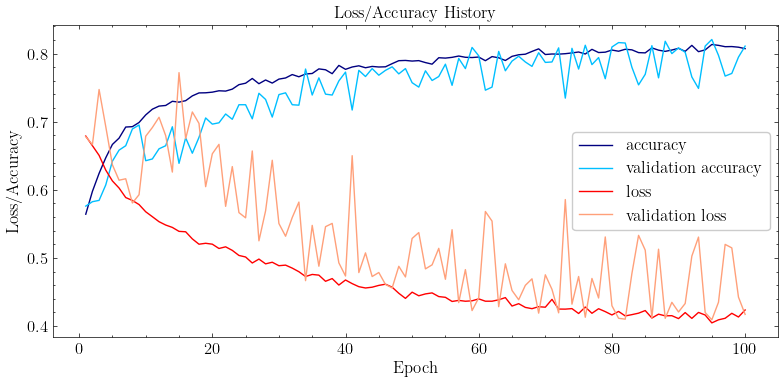

In [65]:
plot_training_curves(history)

2461 3083


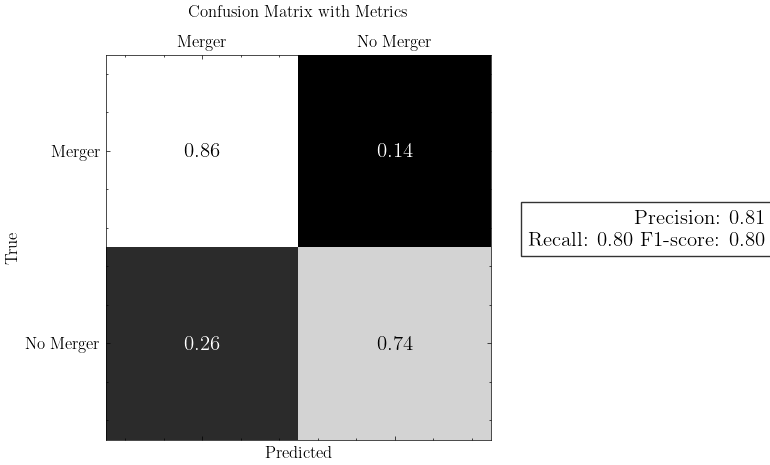

In [73]:
def plot_confusion_matrix(model, data_loader, device, class_names=['Merger', 'No Merger']):
    model.eval()
    y_true = []
    y_pred = []
    
    
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).int()
            
            y_true.extend(y_batch.cpu().numpy().astype(int))
            y_pred.extend(preds.cpu().numpy().astype(int))
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            
            
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    print(correct, total)
    
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=[0, 1])
    cm = cm.astype('float')
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
#     print(np.concatenate(y_true))
    
    # Compute precision, recall, F1
    report = metrics.classification_report(y_true, y_pred, target_names=class_names, digits=2, output_dict=True)
    
    precision = report['weighted avg']['precision']
    recall    = report['weighted avg']['recall']
    f1        = report['weighted avg']['f1-score']
    
    # --- Plot Confusion Matrix ---
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion Matrix with Metrics', y=1.08, fontsize=fs-3)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(class_names, fontsize=fs-3)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(class_names, fontsize=fs-3)
    plt.xlabel('Predicted', fontsize=fs-3)
    plt.ylabel('True', fontsize=fs-3)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center", fontsize=fs,
                    color="white" if cm_norm[i, j] < thresh else "black")

    # --- Add precision, recall, F1 to the figure ---
    plt.figtext(1.29, 0.5,
                f"Precision: {precision:.2f}\nRecall: {recall:.2f}   F1-score: {f1:.2f}",
                ha="right", fontsize=fs, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.show()
    
plot_confusion_matrix(model, test_loader, device, class_names=['Merger', 'No Merger'])

## Beyond Metrics: Visually Understanding Predictions


While it is useful to know **how well** the CNN is making predictions, it is equally important to know **why** the CNN is making particular predictions. The simplest approach to gain insight here is to directly visualize inaccurate predictions.

In [84]:
def collect_predictions(model, data_loader, device):
    model.eval()
    all_images, all_preds, all_labels = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs >= 0.5).int()
            
            all_images.extend(X_batch.cpu())
            all_preds.extend(preds.cpu().numpy().astype(int).flatten())
            all_labels.extend(y_batch.cpu().numpy().astype(int).flatten())
    
    return torch.stack(all_images), np.array(all_preds), np.array(all_labels)

def visualize_fp_fn(model, data_loader, device, class_names=['Merger', 'No Merger'], max_examples=8):
    images, preds, labels = collect_predictions(model, data_loader, device)
    
    # Identify FP and FN
    false_pos_idx = np.where((preds == 1) & (labels == 0))[0]
    false_neg_idx = np.where((preds == 0) & (labels == 1))[0]
        
    #### False Positives ####
    if len(false_pos_idx) > 0:

        fig, axes = plt.subplots(1, min(len(false_pos_idx), max_examples), figsize=(15, 3))
        fig.suptitle("False Positives (Predicted Merger, Actually No Merger)", fontsize=fs, y=0.8)
        for i, idx in enumerate(false_pos_idx[:max_examples]):
            image = images[idx][1, :, :].numpy()
            norm = simple_norm(image, 'log', max_percent=99.75)
            axes[i].imshow(image, aspect='equal', cmap='binary_r', norm=norm)
            axes[i].axis("off")
        plt.show()
    else:
        print("No False Positives found.")
    
    #### False Negatives ####
    if len(false_neg_idx) > 0:
        fig, axes = plt.subplots(1, min(len(false_neg_idx), max_examples), figsize=(15, 3))
        fig.suptitle("False Negatives (Predicted No Merger, Actually Merger)", fontsize=fs, y=0.8)
        for i, idx in enumerate(false_neg_idx[:max_examples]):
            image = images[idx][1, :, :].numpy()
            norm = simple_norm(image, 'log', max_percent=99.75)

            axes[i].imshow(image, aspect='equal', cmap='binary_r', norm=norm)
            axes[i].axis("off")
        plt.show()
    else:
        print("No False Negatives found.")

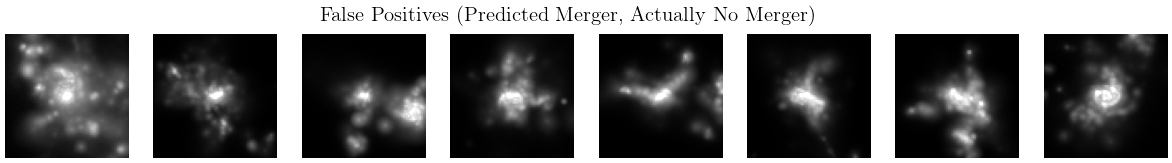

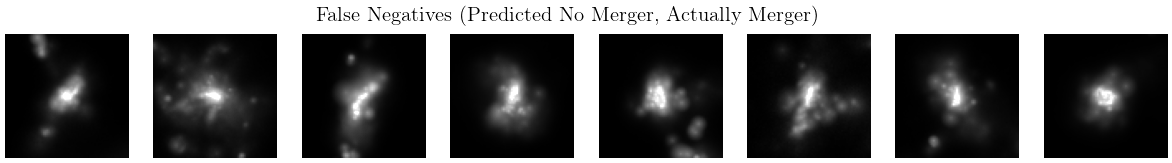

In [86]:
visualize_fp_fn(model, valid_loader, device, class_names=['Merger', 'No Merger'])

What can we glean from these examples?

 **For False Positives**

- Many appear asymmetric or have irregular light distributions, which could be tidal features or lopsided star-forming regions.

- Some have multiple bright clumps (clumpy star formation) that might mimic a double nucleus.

- A few have spiral arms or knots that may have been interpreted as interacting streams.



 **For False Negatives**

- Many look compact and symmetric, with only subtle asymmetries.

- If the ground truth is an actual mergers, these might be late-stage interactions, where the galaxies have already coalesced and tidal debris has faded.

- Some may be minor mergers, where the companion is faint and not easily distinguished against the primary.


## Beyond Metrics: Sensitivity Analysis

A powerful approach to derive insight is to examine features that the network deems are salient (important) in making its prediction. This is especially valuable when the network’s performance exceeds what can be readily explained by conventional visual approaches, as it can reveal subtle, previously overlooked patterns.


### Saliency Map

Saliency maps identify the pixels that most affect the model’s prediction for a given image. More specifically, these maps measure **how strongly the output changes when each pixel changes**.

For an input image $I$ and a scalar output score $S_c$ for class $c$, the saliency map is:

$$
M_{ij} = \left| \frac{\partial S_c}{\partial I_{ij}} \right|
$$

where $(i,j)$ indexes each pixel. The visualization works directly at the input and output levels of the network, without having to look into the network’s intermediate layers.

```{seealso}
The Saliency Map is identical to the Sensitivity Analysis using the Jacobians presented in [](content:references:spectra_part3):
>
$$
J_{\lambda j} = \frac{\partial f_\lambda}{\partial \ell_j}
$$

where:
- $ f_\lambda $: model-predicted flux at wavelength $ \lambda $ for a spectrum,
- $ \ell_j $: input label (scaled),
- $ J \in \mathbb{R}^{N_{\text{wavelengths}} \times N_{\text{labels}}} $.

>
```
The following code computes a saliency map for each provided input image and performs a comparison between map and image.

In [98]:
def compute_saliency_map(model, image_tensor, device):

    model.eval()
    image_tensor = image_tensor.clone().detach().to(device)
    image_tensor.requires_grad = True  # track gradients w.r.t. input

    # Forward pass
    output = model(image_tensor)  # (1, 1)
    score = output[0, 0]  # scalar output 

    # Backward pass
    model.zero_grad()
    score.backward()

    # Get gradient w.r.t. input image
    saliency = image_tensor.grad.data.abs()  # (1, C, H, W)

    # Take max over channels (standard saliency map approach)
    saliency, _ = saliency.max(dim=1)  # (1, H, W)
    saliency = saliency.squeeze().cpu().numpy() 

    # Normalize for visualization
    saliency -= saliency.min()
    saliency /= saliency.max() + 1e-8

    return saliency, score

In [109]:
def show_saliency(image_tensor, saliency_map, pred, truth):
    image_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    
    image = image_np[:, :, 1]
    norm = simple_norm(image, 'log', max_percent=99.75)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    axes[0].set_title("Input Image", fontsize=fs)
    axes[0].axis("off")

    axes[1].imshow(saliency_map, cmap='bwr')
    axes[1].set_title("Saliency Map", fontsize=fs)
    axes[1].axis("off")
    axes[1].text(x=1.2, y=0.5, s=f'Pred: {pred:.2f}\nTruth: {truth:.2f}',
                 transform=axes[1].transAxes, fontsize=fs-3)

    plt.tight_layout()
    plt.show()

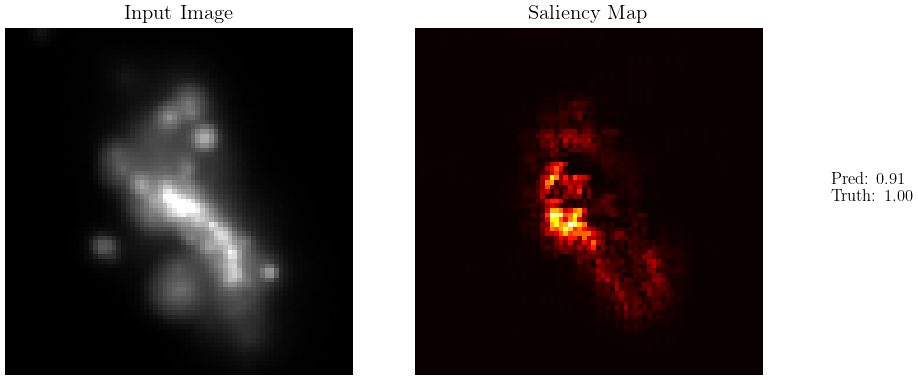

In [152]:
idx = 53 # vary idx to load a different image!

# Select one batch from test set Dataloader
image_batch, label_batch = next(iter(test_loader))
img = image_batch[idx].unsqueeze(0) 

# Compute saliency
saliency, prediction = compute_saliency_map(model, img, device)

show_saliency(img, saliency, prediction.data.cpu().numpy(), label_batch[idx].numpy()[0])

> Bright parts of the saliency map indicate pixels that, if altered, would significantly increase or decrease the model’s predicted merger probability, revealing which parts of the image the network considers most relevant for that classification.

### Gradient-weighted Class Activation Mapping (Grad-CAM)

Simple gradients can be hard to interpret because they operate at pixel scale, which can make the interpretation difficult if there exists noise at such scales. Saliency maps are thus sensitive to noise in gradients.

Instead of highlighting individual pixels, [**Grad-CAM**](https://arxiv.org/abs/1610.02391) identifies **regions** in the image that were important for the prediction. This is done by looking at the feature maps (activations) of the final convolutional layer, weighted by the gradient of the score with respect to the map. The result is a spatially-coarse heatmap identifying where the model 'looked' to make its decision for the classification. 

Given an input image $ I $ and a class score $ y^c $ (for class $c$) the algorithm work by the following:

1. **Forward pass**  
   - Pass the image through the network.  
   - Extract the **feature maps** $ A^k $ from a chosen convolutional layer (often the last one).

2. **Backward pass**  
   - Compute the gradients of the class score with respect to each feature map:  
   
     $$
     \frac{\partial y^c}{\partial A^k}
     $$

3. **Compute channel weights**  
   - Average the gradients across the spatial dimensions \((i,j)\): 
   
     $$
     \alpha_k = \frac{1}{Z} \sum_{i,j} \frac{\partial y^c}{\partial A^k_{i,j}}
     $$
     where $Z$ is the number of spatial locations in each feature map.

4. **Weight the feature maps**  
   - Form the coarse class activation map:  
     
     $$
     L_{\text{Grad-CAM}}(i,j) = \text{ReLU} \left( \sum_k \alpha_k A^k_{i,j} \right)
     $$

5. **Upsample**  
   - Resize $L_{\text{Grad-CAM}}$ to the input image size for visualization.
   
The following implements Grad-CAM in PyTorch:

In [112]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.activations = None
        self.gradients = None

        # Hook the forward and backward pass
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Locate the target conv layer by name
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                module.register_forward_hook(forward_hook)
                module.register_full_backward_hook(backward_hook)
                break
        else:
            raise ValueError(f"Layer '{self.target_layer_name}' not found in model.")

    def generate(self, input_tensor, device="cpu"):
        input_tensor = input_tensor.to(device)
        input_tensor.requires_grad = True

        # Forward pass
        output = self.model(input_tensor)
        score = output[0, 0]

        # Backward pass
        self.model.zero_grad()
        score.backward()

        # Compute CAM
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])  # shape: [C]
        activations = self.activations.squeeze(0)  # shape: [C, H, W]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        cam = torch.sum(activations, dim=0).cpu().numpy() 
        cam = np.maximum(cam, 0)  # ReLU
        cam -= cam.min()
        cam /= cam.max() + 1e-8  # Normalize

        return cam

```{admonition} PyTorch Hooks
:class: important

In PyTorch, a hook is a function that you register on a module or tensor to capture activations (forward pass), capture gradients (backward pass), or optionally modify the intermediate values in the network. In other words, it is a convenient approach to observe or modify intermediate computations in the network.

In the above, we performed the following:

- Specified `self.activations` to be the output of the final convolutional layer (in `forward_hook`).
- Stored the same layer's gradient in `self.gradients` (in `backward_hook`).

```

In [125]:
import cv2

def show_gradcam(cam, image_tensor, alpha=0.2, cmap='jet_r'):
    """
    cam: 2D numpy array (H, W)
    image_tensor: shape (1, 3, H, W), unnormalized and in [0,1]
    """
    img = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = img[:, :, 1]
    norm = simple_norm(image, 'log', max_percent=99.75)
    img_normed = norm(image)  # now in [0,1], shape (H, W)

    # Convert to RGB by stacking 3 channels
    img_rgb = np.dstack([img_normed]*3)  # shape (H, W, 3)

    h, w, _ = img.shape

    cam_resized = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255.0
    overlay = heatmap * alpha + img_rgb * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)


    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    ax[0].set_title("Original Image")
    ax[1].imshow(cam_resized, cmap=cmap)
    ax[1].set_title("Grad-CAM")
    ax[2].imshow(overlay)
    ax[2].set_title("Grad-CAM + Image")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

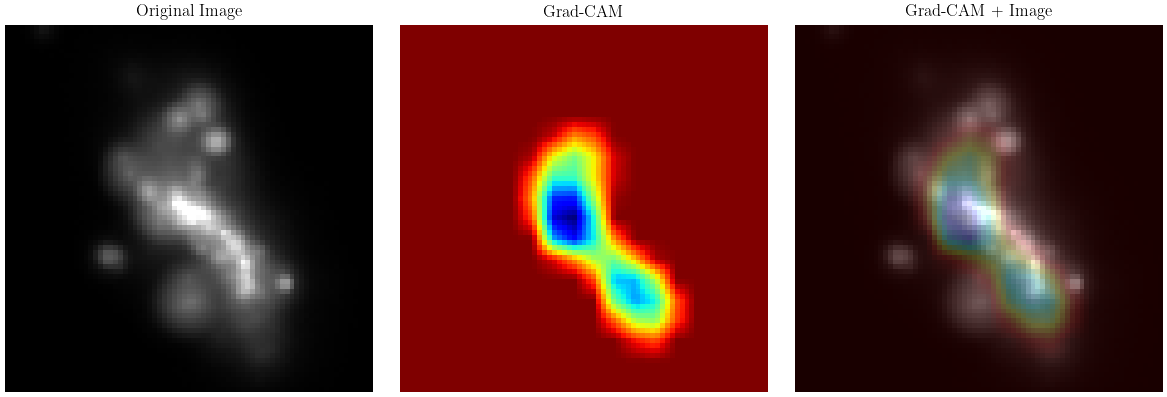

In [151]:
image_batch, label_batch = next(iter(test_loader))
img = image_batch[idx].unsqueeze(0) 

target_layer = 'bn3'  # or 'conv3' depending on your model definition
gradcam = GradCAM(model, target_layer_name=target_layer)

cam = gradcam.generate(img, device=device)
show_gradcam(cam, img)

> Grad-CAM produces a class-specific localization map, highlighting spatially coherent regions of the image that most strongly influence the model’s prediction.



```{admonition} Exercise: Non-Merger Sensitivity
:class: note

The Saliency Map and Grad-CAM implementations above only indicate spatial features in the input image that most **increase** the network’s score for a *merger* (class 1). However, it is often equally important to examine features that most **increase** the score for a *non-merger* (class 0).

To achieve this, we will need to modify `CNNModel` to output **two logits** (one per class) so that sensitivity maps can be computed for either class directly.

---

**Tasks:**

1. One-hot encode the target vector `y`, modifying its dimensions from $(N \times 1)$ to $(N \times 2)$.
2. Modify `CNNModel` to predict *logits* of dimensionality $(N \times 2)$. In the training loop:
     - Training should now use `nn.BCEWithLogitsLoss` as the loss function
     - Calculating the predicted label (for calculating accuracy) should utilize `preds = torch.argmax(y_pred, dim=1)`
     
3. Adapt visualizations functions `compute_saliency_map` and `show_gradcam` to produce sensitivity maps for a merger (class 1) and non-merger (class 0) by indexing the corresponding logit (0 or 1), i.e., `score = output[0, class_idx]`

**Questions:**

- Compare Saliency Maps for class 0 vs class 1:
Do they highlight the same structures? If so, how do their magnitudes differ?

- Compare Grad-CAM maps for class 0 vs class 1:
Are the spatial regions distinct? Which method appears to capture more class-specific localization?

- In the context of binary classification of galaxy mergers, which visualization method is more informative for interpreting model decisions, and why?

<!-- 
In a binary network, the important pixels for one score are usually the important pixels for the other score — just in opposite directions. Without preserving sign information, you lose the class distinction.

In contrast, Grad-CAM aggregates class-specific importance weights over spatial locations, discards negative contributions via ReLU, and produces class-distinct maps. This makes Grad-CAM inherently more class-discriminative. -->